Assignment 6: Gaussian Processes for Classification
Deadline: November 15, 2019 (Friday) at 11.59pm

Katolina Bargiel

1 Generate two classes of data with the same population size (N1=N2=50), sigma = 0.1, mean1 = [2,2], mean2= [3,3]:

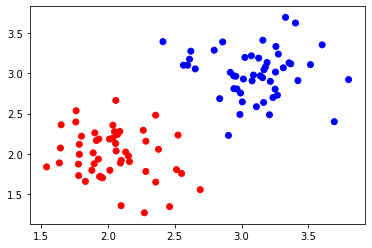

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

N1 = 50
N2 = 50
K = 2
sigma = 0.1

mean = (2, 2)
cov = [[ sigma,0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = ['red'] * len (X1)

mean = (3, 3)
cov = [[ sigma,0], [0, sigma]]
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len (X2)

X = np.concatenate ((X1,X2))
color = np.concatenate((c1,c2))

T= 0* np.ones ([len (X), K])
for n in range(0, len(X)):
    if(n<len(X1)):
        T[n][0] = 1
        
    elif (n>= N1 and n<len(X1)+len(X2)):
        T[n][1] = 1

T= T.astype(int)[:,0]
plt.scatter(X[:, 0], X[:, 1], marker ='o', c=color)
plt.show()

        

2.Write code of Gaussian Processes to classify the two clusters.

3.Use the kernel written on the textbook (page 307, Eq.(6.63)). 
As for its parameters, initially you set them (1.0, 4.0, 1.0, 2.0).

In [47]:
theta0 = 1.0 
theta1 = 4.0
theta2 = 1.0
theta3 = 2.0
Ntotal = N1+N2
beta = 20 
v =1


def k_function(xi, xj) :
   
   
    k = theta0 * np.exp((-theta1/2) * np.power(np.linalg.norm(xi - xj), 2)) + theta2 + theta3 * np.matmul(xi.transpose(), xj)
    
    
    return k 

def cal_C_n() :
    
    Cn = np.empty([Ntotal, Ntotal])
    
    

    for i in range(0,Ntotal):
        for j in range (0, Ntotal):
           
            if i==j:
                
                
                
                Cn[i,j] = k_function(X[i], X[j]) + v
                
            else:
                Cn[i,j] = k_function(X[i], X[j])
                
              

            
    return(Cn)
   





4 Draw the probability map.

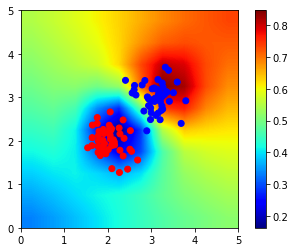

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

alfa = 10
M=3
II = np.identity(M)
C_n = cal_C_n()


def sigmoid(x):
    sig = 1 / (1 + (np.exp(-x)))
               
    return sig

def sigmoid_bar(a_old):
    sigmoidbar = np.zeros([Ntotal])
    for i in range(Ntotal):
        a = sigmoid(a_old[i])
        sigmoidbar[i]= a
      
    return sigmoidbar
       

def calanew(a_old, w, sigmoid_bar_new):
   
    
    H = -(np.linalg.inv(C_n) + w)
  
    a_new_1 = np.linalg.inv(H)
    a_new_2 = T - sigmoid_bar_new - np.matmul(np.linalg.inv(C_n), a_old)
    a_new = a_old - np.matmul(a_new_1, a_new_2)
    
    return a_new



def calw(sigmoid_new):
    w = np.zeros([Ntotal, Ntotal])
    for i in range(Ntotal):
        w[i, i] = (sigmoid_new[i] * (1- sigmoid_new[i]))   
    return w

def diff(a_old, a_new):
    sum =0
    for i in range(M):
        a = np.absolute(a_old[i] - a_new[i])
       
        sum = sum + a
    return sum    
        
    
        
def cal_a_mean(C_n):
    
    a_old= np.zeros([Ntotal])
    sigmoid_new = sigmoid_bar(a_old)
    w = calw(sigmoid_new)
    epsilon = 0.001
    difference= 10
    count = 1000
    while abs(difference)>epsilon:
        count = count -1
        if(count == 0):
            break
        a_new = calanew(a_old, w, sigmoid_new)
        difference=diff(a_old, a_new)
        sigmoid_new = sigmoid_bar(a_new)
       
        w_new = calw(sigmoid_new)
        a_old= a_new.copy()

    return a_new   
        
        
def predictive(mu, S_star):
    
    P = sigmoid(np.asscalar(mu)/(1 + ((np.pi/8)* np.asscalar(S_star))**(1/2)))
    return P

def k_Star(i, j):
        x_new =np.array([i, j])
        k= np.zeros((Ntotal,1))
        for z in range(0, Ntotal):
            k[z,0] = k_function(x_new, X[z])     
        
        return(k)
    

def calmu(k, a, C_n):
    t1 = np.matmul(k.transpose(), np.linalg.inv(C_n))
    mu = np.matmul(t1, a)
    
    return mu
    
def cal_S_star(C, k, w, C_n): 

    tmp = np.linalg.inv(np.linalg.inv(w)+ C_n)
    tmp1 = np.matmul(k.transpose(), tmp)
    tmp2 = np.matmul(tmp1, k)
    S = C - tmp2
    
    return S
    

a = cal_a_mean(C_n)
sigmoid_newest = sigmoid_bar(a)
w = calw(sigmoid_newest)
BIGMATRIX = np.empty([10,10])
for i in range(10):
    for j in range(10):
        
        x_star = np.array([i/2, j/2])
        
        k = k_Star(i/2, j/2)
        C = k_function(x_star, x_star) + 1
        mu = calmu(k, a, C_n)
        S_star = cal_S_star(C, k, w, C_n)
        b = predictive(mu, S_star)
        BIGMATRIX[i, j] = b


plt.scatter(X[:, 0], X[:, 1], marker ='o', c=color)
plt.imshow(1-BIGMATRIX.T, interpolation='bilinear', origin='lower', cmap=plt.cm.jet, extent = (0,5,0,5))
plt.colorbar()
plt.show()


5 Change the kernel parameters to (1.0, 0.25, 0, 0) to obtain:

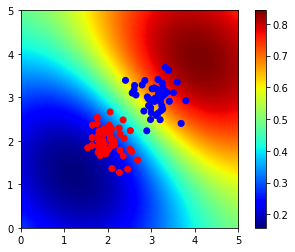

In [49]:
theta0 = 1.0 
theta1 = 0.25
theta2 = 0
theta3 = 0
Ntotal = N1+N2
beta = 20 
v =1


def k_function(xi, xj) :
   
   
    k = theta0 * np.exp((-theta1/2) * np.power(np.linalg.norm(xi - xj), 2)) + theta2 + theta3 * np.matmul(xi.transpose(), xj)
    
    
    return k 

def cal_C_n() :
    
    Cn = np.empty([Ntotal, Ntotal])
    
    

    for i in range(0,Ntotal):
        for j in range (0, Ntotal):
           
            if i==j:
                
                
                
                Cn[i,j] = k_function(X[i], X[j]) + v
                
            else:
                Cn[i,j] = k_function(X[i], X[j])
          
    return(Cn)
   
C_n = cal_C_n()


def sigmoid(x):
    sig = 1 / (1 + (np.exp(-x)))
               
    return sig

def sigmoid_bar(a_old):
    sigmoidbar = np.zeros([Ntotal])
    for i in range(Ntotal):
        a = sigmoid(a_old[i])
        sigmoidbar[i]= a
      
    return sigmoidbar
       

def calanew(a_old, w, sigmoid_bar_new):
    
    H = -(np.linalg.inv(C_n) + w)
  
    a_new_1 = np.linalg.inv(H)
    a_new_2 = T - sigmoid_bar_new - np.matmul(np.linalg.inv(C_n), a_old)
    a_new = a_old - np.matmul(a_new_1, a_new_2)
    
    return a_new



def calw(sigmoid_new):
    w = np.zeros([Ntotal, Ntotal])
    for i in range(Ntotal):
        w[i, i] = (sigmoid_new[i] * (1- sigmoid_new[i]))   
    return w

def diff(a_old, a_new):
    sum =0
    for i in range(M):
        a = np.absolute(a_old[i] - a_new[i])
       
        sum = sum + a
    return sum    
        
    
        
def cal_a_mean(C_n):
    
    a_old= np.zeros([Ntotal])
    sigmoid_new = sigmoid_bar(a_old)
    w = calw(sigmoid_new)
    epsilon = 0.001
    difference= 10
    count = 1000
    while abs(difference)>epsilon:
        count = count -1
        if(count == 0):
            break
        a_new = calanew(a_old, w, sigmoid_new)
        difference=diff(a_old, a_new)
        sigmoid_new = sigmoid_bar(a_new)
       
        w_new = calw(sigmoid_new)
        a_old= a_new.copy()

    return a_new   
        
        
def predictive(mu, S_star):
    
    P = sigmoid(np.asscalar(mu)/(1 + ((np.pi/8)* np.asscalar(S_star))**(1/2)))
    return P

def k_Star(i, j):
        x_new =np.array([i, j])
        k= np.zeros((Ntotal,1))
        for z in range(0, Ntotal):
            k[z,0] = k_function(x_new, X[z])     
        
        return(k)
    

def calmu(k, a, C_n):
    t1 = np.matmul(k.transpose(), np.linalg.inv(C_n))
    mu = np.matmul(t1, a)
    
    return mu
    
def cal_S_star(C, k, w, C_n): 

    tmp = np.linalg.inv(np.linalg.inv(w)+ C_n)
    tmp1 = np.matmul(k.transpose(), tmp)
    tmp2 = np.matmul(tmp1, k)
    S = C - tmp2
    
    return S
    

a = cal_a_mean(C_n)
sigmoid_newest = sigmoid_bar(a)
w = calw(sigmoid_newest)
BIGMATRIX = np.empty([30,30])
for i in range(30):
    for j in range(30):
        
        x_star = np.array([i/6, j/6])
        
        k = k_Star(i/6, j/6)
        C = k_function(x_star, x_star) + 1
        mu = calmu(k, a, C_n)
        S_star = cal_S_star(C, k, w, C_n)
        b = predictive(mu, S_star)
        BIGMATRIX[i, j] = b


plt.scatter(X[:, 0], X[:, 1], marker ='o', c=color)
plt.imshow(1-BIGMATRIX.T, interpolation='bilinear', origin='lower', cmap=plt.cm.jet, extent = (0,5,0,5))
plt.colorbar()
plt.show()





6 Discuss why the new parameters generate a less precise probability map.

They generate a less predictive value due to the fact that kernel is not as expressive. By setting theta1 very small and theta3 and 4 as zero, we give kernel less flexibility of expression. That's due to the fact that theta1 and 3 are the ones that make the result vary with more variance in input, so especially setting theta3 to 0, generates less precise probability map.




8 Change the means of the clusters to mean1 = [3,3], mean2= [3.2,3.2], and cov1 = [[0.003, 0],[0.003]], cov2= [[0.3,0],[0,0.3]]:

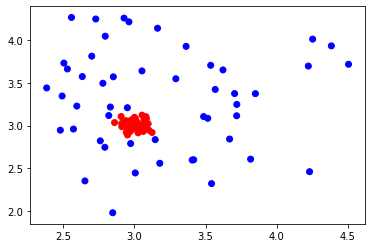

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

N1 = 50
N2 = 50
K = 2
sigma = 0.1

mean = (3, 3)
cov = [[0.003, 0],[0, 0.003]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = ['red'] * len (X1)

mean = (3.2, 3.2)
cov = [[0.3,0],[0,0.3]]
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len (X2)

X = np.concatenate ((X1,X2))
color = np.concatenate((c1,c2))

T= 0* np.ones ([len (X), K])
for n in range(0, len(X)):
    if(n<len(X1)):
        T[n][0] = 1
        
    elif (n>= N1 and n<len(X1)+len(X2)):
        T[n][1] = 1

T= T.astype(int)[:,0]
plt.scatter(X[:, 0], X[:, 1], marker ='o', c=color)
plt.show()

        

7 Change the kernel parameters back to (1.0, 4.0, 1.0, 2.0).

9 Classify and show the probability map.


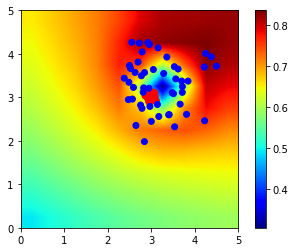

In [51]:
theta0 = 1.0
theta1 = 4.0
theta2 = 1.0
theta3 = 2.0
Ntotal = N1+N2
beta = 20 
v =1


def k_function(xi, xj) :
   
   
    k = theta0 * np.exp((-theta1/2) * np.power(np.linalg.norm(xi - xj), 2)) + theta2 + theta3 * np.matmul(xi.transpose(), xj)
    
    
    return k 

def cal_C_n() :
    
    Cn = np.empty([Ntotal, Ntotal])
    
    

    for i in range(0,Ntotal):
        for j in range (0, Ntotal):
           
            if i==j:
                
                
                
                Cn[i,j] = k_function(X[i], X[j]) + v
                
            else:
                Cn[i,j] = k_function(X[i], X[j])
                
              

            
    return(Cn)
   
C_n = cal_C_n()


def sigmoid(x):
    sig = 1 / (1 + (np.exp(-x)))
               
    return sig

def sigmoid_bar(a_old):
    sigmoidbar = np.zeros([Ntotal])
    for i in range(Ntotal):
        a = sigmoid(a_old[i])
        sigmoidbar[i]= a
      
    return sigmoidbar
       

def calanew(a_old, w, sigmoid_bar_new):
    
    H = -(np.linalg.inv(C_n) + w)
  
    a_new_1 = np.linalg.inv(H)
    a_new_2 = T - sigmoid_bar_new - np.matmul(np.linalg.inv(C_n), a_old)
    a_new = a_old - np.matmul(a_new_1, a_new_2)
    
    return a_new



def calw(sigmoid_new):
    w = np.zeros([Ntotal, Ntotal])
    for i in range(Ntotal):
        w[i, i] = (sigmoid_new[i] * (1- sigmoid_new[i]))   
    return w

def diff(a_old, a_new):
    sum =0
    for i in range(M):
        a = np.absolute(a_old[i] - a_new[i])
       
        sum = sum + a
    return sum    
        
    
        
def cal_a_mean(C_n):
    
    a_old= np.zeros([Ntotal])
    sigmoid_new = sigmoid_bar(a_old)
    w = calw(sigmoid_new)
    epsilon = 0.001
    difference= 10
    count = 1000
    while abs(difference)>epsilon:
        count = count -1
        if(count == 0):
            break
        a_new = calanew(a_old, w, sigmoid_new)
        difference=diff(a_old, a_new)
        sigmoid_new = sigmoid_bar(a_new)
       
        w_new = calw(sigmoid_new)
        a_old= a_new.copy()

    return a_new   
        
        
def predictive(mu, S_star):
    
    P = sigmoid(np.asscalar(mu)/(1 + ((np.pi/8)* np.asscalar(S_star))**(1/2)))
    return P

def k_Star(i, j):
        x_new =np.array([i, j])
        k= np.zeros((Ntotal,1))
        for z in range(0, Ntotal):
            k[z,0] = k_function(x_new, X[z])     
        
        return(k)
    

def calmu(k, a, C_n):
    t1 = np.matmul(k.transpose(), np.linalg.inv(C_n))
    mu = np.matmul(t1, a)
    
    return mu
    
def cal_S_star(C, k, w, C_n): 

    tmp = np.linalg.inv(np.linalg.inv(w)+ C_n)
    tmp1 = np.matmul(k.transpose(), tmp)
    tmp2 = np.matmul(tmp1, k)
    S = C - tmp2
    
    return S
    

a = cal_a_mean(C_n)
sigmoid_newest = sigmoid_bar(a)
w = calw(sigmoid_newest)
BIGMATRIX = np.empty([10,10])
for i in range(10):
    for j in range(10):
        
        x_star = np.array([i/2, j/2])
        
        k = k_Star(i/2, j/2)
        C = k_function(x_star, x_star) + 1
        mu = calmu(k, a, C_n)
        S_star = cal_S_star(C, k, w, C_n)
        b = predictive(mu, S_star)
        BIGMATRIX[i, j] = b


plt.scatter(X[:, 0], X[:, 1], marker ='o', c=color)
plt.imshow(1-BIGMATRIX.T, interpolation='bilinear', origin='lower', cmap=plt.cm.jet, extent = (0,5,0,5))
plt.colorbar()
plt.show()


10 Change the means and clusters back to #1 above, and add another cluster belonging to C2, with mean=[1,1] and sigma=0.1

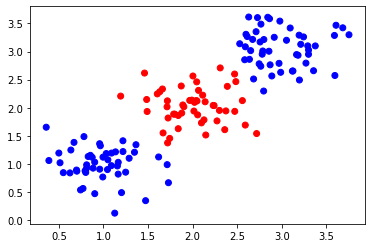

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

N1 = 50
N2 = 100
K = 2
sigma = 0.1

mean = (2, 2)
cov = [[ sigma,0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = ['red'] * len (X1)

mean = (3, 3)
cov = [[ sigma,0], [0, sigma]]
X2 = np.random.multivariate_normal(mean, cov, (N2//2))
c2 = ['blue'] * len (X2/2)

mean = (1, 1)
cov = [[ sigma,0], [0, sigma]]
X3 = np.random.multivariate_normal(mean, cov, (N2//2))
c3 = ['blue'] * len (X2/2)

X_tmp = np.concatenate ((X1,X2))
X = np.concatenate ((X_tmp,X3))
color_tmp = np.concatenate((c1,c2))
color = np.concatenate((color_tmp,c3))

T= 0* np.ones ([len (X), K])
for n in range(0, len(X)):
    if(n<len(X1)):
        T[n][0] = 1
        
    elif (n>= N1 and n<len(X1)+len(X2)):
        T[n][1] = 1

T= T.astype(int)[:,0]
plt.scatter(X[:, 0], X[:, 1], marker ='o', c=color)
plt.show()

        

11 Classify and show the probability map


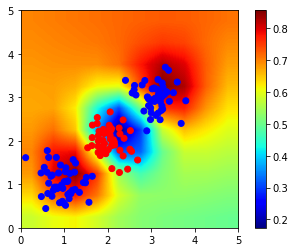

In [37]:
theta0 = 1.0
theta1 = 4.0
theta2 = 1.0
theta3 = 2.0
Ntotal = N1+N2
beta = 20 
v =1


def k_function(xi, xj) :
   
   
    k = theta0 * np.exp((-theta1/2) * np.power(np.linalg.norm(xi - xj), 2)) + theta2 + theta3 * np.matmul(xi.transpose(), xj)
    
    
    return k 

def cal_C_n() :
    
    Cn = np.empty([Ntotal, Ntotal])
    
    

    for i in range(0,Ntotal):
        for j in range (0, Ntotal):
           
            if i==j:
                
                
                
                Cn[i,j] = k_function(X[i], X[j]) + v
                
            else:
                Cn[i,j] = k_function(X[i], X[j])
                
              

            
    return(Cn)
   
C_n = cal_C_n()


def sigmoid(x):
    sig = 1 / (1 + (np.exp(-x)))
               
    return sig

def sigmoid_bar(a_old):
    sigmoidbar = np.zeros([Ntotal])
    for i in range(Ntotal):
        a = sigmoid(a_old[i])
        sigmoidbar[i]= a
      
    return sigmoidbar
       

def calanew(a_old, w, sigmoid_bar_new):
    
    H = -(np.linalg.inv(C_n) + w)
  
    a_new_1 = np.linalg.inv(H)
    a_new_2 = T - sigmoid_bar_new - np.matmul(np.linalg.inv(C_n), a_old)
    a_new = a_old - np.matmul(a_new_1, a_new_2)
    
    return a_new



def calw(sigmoid_new):
    w = np.zeros([Ntotal, Ntotal])
    for i in range(Ntotal):
        w[i, i] = (sigmoid_new[i] * (1- sigmoid_new[i]))   
    return w

def diff(a_old, a_new):
    sum =0
    for i in range(M):
        a = np.absolute(a_old[i] - a_new[i])
       
        sum = sum + a
    return sum    
        
    
        
def cal_a_mean(C_n):
    
    a_old= np.zeros([Ntotal])
    sigmoid_new = sigmoid_bar(a_old)
    w = calw(sigmoid_new)
    epsilon = 0.001
    difference= 10
    count = 1000
    while abs(difference)>epsilon:
        count = count -1
        if(count == 0):
            break
        a_new = calanew(a_old, w, sigmoid_new)
        difference=diff(a_old, a_new)
        sigmoid_new = sigmoid_bar(a_new)
       
        w_new = calw(sigmoid_new)
        a_old= a_new.copy()

    return a_new   
        
        
def predictive(mu, S_star):
    
    P = sigmoid(np.asscalar(mu)/(1 + ((np.pi/8)* np.asscalar(S_star))**(1/2)))
    return P

def k_Star(i, j):
        x_new =np.array([i, j])
        k= np.zeros((Ntotal,1))
        for z in range(0, Ntotal):
            k[z,0] = k_function(x_new, X[z])     
        
        return(k)
    

def calmu(k, a, C_n):
    t1 = np.matmul(k.transpose(), np.linalg.inv(C_n))
    mu = np.matmul(t1, a)
    
    return mu
    
def cal_S_star(C, k, w, C_n): 

    tmp = np.linalg.inv(np.linalg.inv(w)+ C_n)
    tmp1 = np.matmul(k.transpose(), tmp)
    tmp2 = np.matmul(tmp1, k)
    S = C - tmp2
    
    return S
    

a = cal_a_mean(C_n)
sigmoid_newest = sigmoid_bar(a)
w = calw(sigmoid_newest)
BIGMATRIX = np.empty([10,10])
for i in range(10):
    for j in range(10):
        
        x_star = np.array([i/2, j/2])
        
        k = k_Star(i/2, j/2)
        C = k_function(x_star, x_star) + 1
        mu = calmu(k, a, C_n)
        S_star = cal_S_star(C, k, w, C_n)
        b = predictive(mu, S_star)
        BIGMATRIX[i, j] = b


plt.scatter(X[:, 0], X[:, 1], marker ='o', c=color)
plt.imshow(1-BIGMATRIX.T, interpolation='bilinear', origin='lower', cmap=plt.cm.jet, extent = (0,5,0,5))
plt.colorbar()
plt.show()